In [2]:
#!pip install yfinance
#!pip install prophet
#!pip install scikit-learn
#!pip install numpy
#!pip install spacy
#!pip install matplotlib
#!pip install seaborn

In [103]:
import pandas as pd
from datetime import date
import yfinance as yf
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import subprocess
import os
import spacy
from prophet.diagnostics import cross_validation
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap

In [4]:
# News data
news = pd.read_csv('C:/Users/ayata/Desktop/ammagamma-lab/project/news.csv')
news.head()

,Unnamed: 0,txt,url,date
0,0,"\r\nBrent Oil - Murrey math lines: Brent, S&P ...",http://www.forexrate.co.uk/Brent-Oil---Murrey-...,07-06-2024 02:10
1,1,\r\nGBPUSD - GBP/USD Forecast: Pound Sterling ...,http://www.forexrate.co.uk/GBPUSD---GBP-USD-Fo...,07-06-2024 01:45
2,2,\r\nCommodities Prices - Nat-Gas Prices Retrea...,http://www.forexrate.co.uk/Commodities-Prices-...,06-06-2024 03:18
3,3,\r\nEURUSD - EUR/USD completes a downward impu...,http://www.forexrate.co.uk/EURUSD---EUR-USD-co...,06-06-2024 02:28
4,4,\r\nCrude Oil - FxWirePro- Crude oil Daily Out...,http://www.forexrate.co.uk/Crude-Oil---FxWireP...,05-06-2024 03:09


In [5]:
news.columns
news.shape[0]

2611

In [6]:
news = news[['txt', 'date']].drop_duplicates()
news.shape[0]

2567

In [7]:
news['txt'] = news['txt'].str.replace('\n', '').str.replace('\t', '')

In [8]:
def invert_date(date_string):
    day, month, year = date_string.split("-")
    return f"{year}-{month}-{day}"

In [9]:
news['date'] = pd.to_datetime(news['date'].str.split().apply(lambda x: x[0]).apply(invert_date))
news.dtypes

txt             object
date    datetime64[ns]
dtype: object

In [10]:
news = news[news['date'] >= '2020-01-01']
news.tail()

,txt,date
2337,\rEURGBP - Safe-haven currencies jump after U....,2020-01-03
2338,\rUSDJPY - USD/JPY: the market response around...,2020-01-02
2339,"\rSilver Price - Gold, silver rise marginally ...",2020-01-02
2340,\rOil Price - ATF cost up 2.6%; non-subsidised...,2020-01-01
2341,"\rGold Price - Gold eases by Rs 131, silver do...",2020-01-01


In [110]:
# Forex data
start = pd.to_datetime('2010-01-01')
end = date.today()
ticker = 'EURUSD=X'
forex = yf.download(ticker, start, end)['Close']
forex = forex.rename(ticker.lower().split('=', 1)[0] + '_close').to_frame().reset_index().rename(columns={'Date': 'date'})
forex = forex[forex['date'] >= '2020-01-01']
forex.head()
print("There are no missing values." if not forex.isnull().any().any()\
      else "There are missing values in the dataframe.")

In [15]:
# Forecast future values based on past values
forex_1 = forex.rename(columns={'date': 'ds', 'eurusd_close': 'y'})

In [16]:
train_ratio = 0.7 # Create training and test sets
 
total_rows = forex_1.shape[0]
train_end = int(total_rows*train_ratio)

forex_train = forex_1[:train_end]
forex_test = forex_1[train_end:]

In [17]:
m = Prophet()
m.fit(forex_train)

14:03:18 - cmdstanpy - INFO - Chain [1] start processing
14:03:19 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
forex_test_1 = m.predict(forex_test[['ds']])[['ds', 'yhat_lower', 'yhat_upper', 'yhat']] # Compute predictions for the test set
forex_test_1 = forex_test_1.merge(forex_test, left_on='ds', right_on='ds')
forex_test_1.tail()

,ds,yhat_lower,yhat_upper,yhat,y
343,2024-06-04,0.459066,1.643628,1.063236,1.090739
344,2024-06-05,0.452178,1.644815,1.062785,1.088187
345,2024-06-06,0.452586,1.643483,1.062442,1.087453
346,2024-06-07,0.449019,1.645088,1.061297,1.089443
347,2024-06-10,0.445230,1.641640,1.058193,1.077888


In [19]:
def compute_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    percent_mae_value = (mae / actual.mean()) * 100
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    bias_value = (predicted - actual).mean()
    return mae, percent_mae_value, rmse, bias_value

In [20]:
mae, percent_mae_value, rmse, bias_value = compute_metrics(forex_test_1['y'], forex_test_1['yhat'])
print(f"Model Evaluation Metrics:\n")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Percent Mean Absolute Error (%MAE): {percent_mae_value:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Bias: {bias_value:.4f}")

Model Evaluation Metrics:

Mean Absolute Error (MAE): 0.0386
Percent Mean Absolute Error (%MAE): 3.57%
Root Mean Square Error (RMSE): 0.0483
Bias: -0.0356


In [21]:
# Forecast future values using rolling mean with a window size of 7
forex['yhat_rm'] = forex['eurusd_close'].rolling(7).mean()
forex_test_rm = forex[train_end:] # Extract the test set

In [23]:
mae_rm, percent_mae_value_rm, rmse_rm, bias_value_rm = compute_metrics(forex_test_rm['eurusd_close'], forex_test_rm['yhat_rm'])
print(f"Model Evaluation Metrics:\n")
print(f"Mean Absolute Error (MAE): {mae_rm:.4f}")
print(f"Percent Mean Absolute Error (%MAE): {percent_mae_value_rm:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse_rm:.4f}")
print(f"Bias: {bias_value_rm:.4f}")

Model Evaluation Metrics:

Mean Absolute Error (MAE): 0.0045
Percent Mean Absolute Error (%MAE): 0.41%
Root Mean Square Error (RMSE): 0.0057
Bias: -0.0000


In [24]:
# Train a model for sentiment prediction
subprocess.run('git clone https://github.com/explosion/projects.git spacy-projects', shell=True)

CompletedProcess(args='git clone https://github.com/explosion/projects.git spacy-projects', returncode=1)

In [25]:
text_file = open('C:/Users/ayata/Desktop/ammagamma-lab/project/FinancialPhraseBank_AllAgree.txt', 'r') # Prepare the training set
financial = text_file.read().split('\n')
financial = pd.DataFrame(financial, columns=['text'])
financial.tail()

,text
2260,HELSINKI Thomson Financial - Shares in Cargote...
2261,LONDON MarketWatch -- Share prices ended lower...
2262,Operating profit fell to EUR 35.4 mn from EUR ...
2263,Sales in Finland decreased by 10.5 % in Januar...
2264,


In [26]:
financial[['text', 'sentiment']] = financial['text'].str.split('@', expand=True)
financial = financial.iloc[:2264, :] # Remove the last row, since it's empty
financial.head()

,text,sentiment
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [27]:
financial['sentiment_id'] = financial['sentiment'].apply(lambda x: 0 if x == 'negative' else (1 if x == 'neutral' else 2))
financial['text_id'] = "T" + financial.index.astype(str)
financial = financial[['text', 'sentiment_id', 'text_id']]
financial.head()

,text,sentiment_id,text_id
0,"According to Gran , the company has no plans t...",1,T0
1,"For the last quarter of 2010 , Componenta 's n...",2,T1
2,"In the third quarter of 2010 , net sales incre...",2,T2
3,Operating profit rose to EUR 13.1 mn from EUR ...,2,T3
4,"Operating profit totalled EUR 21.1 mn , up fro...",2,T4


In [28]:
financial_1 = financial.sample(frac=1) # Shuffle the data
train_ratio_s = 0.7
total_rows_s = financial_1.shape[0]
train_end_s = int(total_rows_s*train_ratio_s)
financial_train = financial_1[:train_end_s] # Training set
remaining_s = financial_1[train_end_s:]
test_ratio_s = 2/3
remaining_rows_s = remaining_s.shape[0]
test_end_s = int(remaining_rows_s*test_ratio_s)

In [34]:
financial_test = remaining_s[:test_end_s] # Test set
financial_dev = remaining_s[test_end_s:] # Development set

In [36]:
path = 'C:/Users/ayata/Desktop/ammagamma-lab/project/news/assets'
financial_train.to_csv(path + 'train.tsv', sep='\t', index=False, header=False)
financial_test.to_csv(path + 'test.tsv', sep='\t', index=False, header=False)
financial_dev.to_csv(path + 'dev.tsv', sep='\t', index=False, header=False)

In [37]:
os.chdir('C:/Users/ayata/Desktop/ammagamma-lab/project/news')
!spacy project assets
!spacy project run preprocess
!spacy project run train
!spacy project run evaluate

ℹ Fetching 4 asset(s)
✔ Downloaded asset
C:\Users\ayata\Desktop\ammagamma-lab\project\news\assets\categories.txt
✔ Downloaded asset
C:\Users\ayata\Desktop\ammagamma-lab\project\news\assets\train.tsv
✔ Downloaded asset
C:\Users\ayata\Desktop\ammagamma-lab\project\news\assets\dev.tsv
✔ Downloaded asset
C:\Users\ayata\Desktop\ammagamma-lab\project\news\assets\test.tsv

================================= preprocess =================================
ℹ Skipping 'preprocess': nothing changed

=================================== train ===================================
ℹ Skipping 'train': nothing changed

================================== evaluate ==================================
ℹ Skipping 'evaluate': nothing changed


In [38]:
# Predict the sentiment of scraped news
nlp_s = spacy.load("./training/cnn/model-best")
sentiments = []
for doc in nlp_s.pipe(news['txt']):
    sentiments.append(doc.cats)

In [39]:
news['sentiment'] = sentiments

def get_max_key(d):
    return max(d, key=d.get)

news['sentiment'] = news['sentiment'].apply(get_max_key)
news.head()

,txt,date,sentiment
0,"\rBrent Oil - Murrey math lines: Brent, S&P 50...",2024-06-07,amusement
1,\rGBPUSD - GBP/USD Forecast: Pound Sterling fa...,2024-06-07,amusement
2,\rCommodities Prices - Nat-Gas Prices Retreat ...,2024-06-06,amusement
3,\rEURUSD - EUR/USD completes a downward impuls...,2024-06-06,amusement
4,\rCrude Oil - FxWirePro- Crude oil Daily Outlo...,2024-06-05,amusement


In [40]:
# Include the sentiment as an additional regressor in the first model
forex_train_s = forex_train.merge(news, left_on='ds', right_on='date')
forex_train_s['sentiment'] = forex_train_s['sentiment'].apply(lambda x: 0 if x == 'negative' else (1 if x == 'neutral' else 2))
forex_train_s = forex_train_s[['ds', 'y', 'sentiment']]
forex_train_s.head()

,ds,y,sentiment
0,2020-01-01,1.122083,2
1,2020-01-01,1.122083,2
2,2020-01-02,1.122083,2
3,2020-01-02,1.122083,2
4,2020-01-03,1.117144,2


In [41]:
forex_test_s = forex_test.merge(news, left_on='ds', right_on='date')
forex_test_s['sentiment'] = forex_test_s['sentiment'].apply(lambda x: 0 if x == 'negative' else (1 if x == 'neutral' else 2))
forex_test_s = forex_test_s[['ds', 'y', 'sentiment']]
forex_test_s.head()

forex_s = pd.concat([forex_train_s, forex_test_s])
forex_s.shape[0]

m_s = Prophet()
m_s.add_regressor('sentiment')
m_s.fit(forex_test_s)

14:03:44 - cmdstanpy - INFO - Chain [1] start processing
14:03:44 - cmdstanpy - INFO - Chain [1] done processing


In [42]:
forex_test_s_1 = m_s.predict(forex_test_s[['ds', 'sentiment']])[['ds', 'yhat_lower', 'yhat_upper', 'yhat']] # Compute predictions for the test set
forex_test_s_1 = forex_test_s_1.merge(forex_test_s, left_on='ds', right_on='ds')
forex_test_s_1.tail()

mae_s, percent_mae_value_s, rmse_s, bias_value_s = compute_metrics(forex_test_s_1['y'], forex_test_s_1['yhat'])
print(f"Model Evaluation Metrics:\n")
print(f"Mean Absolute Error (MAE): {mae_s:.4f}")
print(f"Percent Mean Absolute Error (%MAE): {percent_mae_value_s:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse_s:.4f}")
print(f"Bias: {bias_value_s:.4f}")


Model Evaluation Metrics:

Mean Absolute Error (MAE): 0.0049
Percent Mean Absolute Error (%MAE): 0.45%
Root Mean Square Error (RMSE): 0.0062
Bias: 0.0001


In [43]:
# Perform cross-validation
cut_offs = pd.DataFrame(forex_s[(forex_s['ds'] >= '2024-01-01') & (forex_s['ds'] <= '2024-05-20')]['ds'])

date_strings = [timestamp.strftime('%Y-%m-%d') for timestamp in cut_offs['ds'].to_list()] # Fix dates here
date_strings

m_s_cv = cross_validation(m_s, cutoffs = pd.to_datetime(date_strings), period = '1 days', horizon = '14 days')
m_s_cv

  0%|          | 0/201 [00:00<?, ?it/s]

14:03:45 - cmdstanpy - INFO - Chain [1] start processing
14:03:45 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/201 [00:00<02:28,  1.35it/s]14:03:45 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/201 [00:01<02:11,  1.51it/s]14:03:46 - cmdstanpy - INFO - Chain [1] start processing
14:03:46 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/201 [00:02<02:19,  1.42it/s]14:03:47 - cmdstanpy - INFO - Chain [1] start processing
14:03:47 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/201 [00:02<02:21,  1.39it/s]14:03:48 - cmdstanpy - INFO - Chain [1] start processing
14:03:48 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 5/201 [00:03<02:20,  1.40it/s]14:03:48 - cmdstanpy - INFO - Chain [1] start processing
14:03:49 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 6/201 [00:04<02:11,  1.48it/s]14:03:49 - cmdstanpy - INFO - Chain [1] 

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-01-02,1.106522,1.098894,1.113895,1.103875,2024-01-01
1,2024-01-02,1.106522,1.099175,1.113633,1.103875,2024-01-01
2,2024-01-03,1.107089,1.099697,1.114072,1.094176,2024-01-01
3,2024-01-03,1.107089,1.100080,1.114630,1.094176,2024-01-01
4,2024-01-04,1.107783,1.100265,1.115379,1.092777,2024-01-01
...,...,...,...,...,...,...
3965,2024-05-30,1.074292,1.066177,1.083132,1.080182,2024-05-20
3966,2024-05-31,1.074260,1.065644,1.083022,1.083541,2024-05-20
3967,2024-05-31,1.074260,1.065459,1.083380,1.083541,2024-05-20
3968,2024-06-03,1.073664,1.064100,1.083071,1.085305,2024-05-20


Accuracy: 0.4532


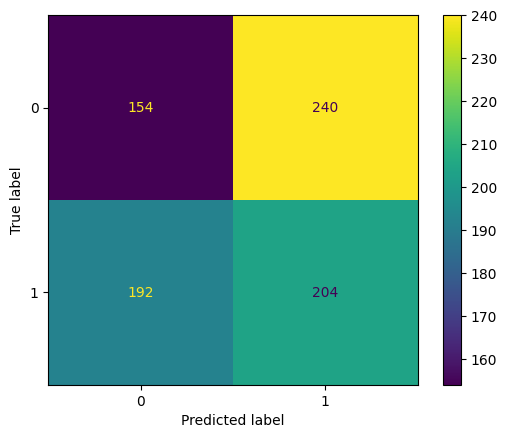

In [44]:
# Is the model able to predict y increase/decrease 14 days from the cutoff date?
m_s_cv['days_difference'] = m_s_cv['ds'] - m_s_cv['cutoff']
m_s_cv['days_difference'] = m_s_cv['days_difference'].dt.days
m_s_cv.head()

m_s_cv_selected = m_s_cv[m_s_cv['days_difference'] == 14][['ds', 'yhat', 'y', 'cutoff']]
m_s_cv_selected = m_s_cv_selected.rename(columns={'y': 'y_ds'}).merge(forex_s[['ds', 'y']], how='left', left_on='cutoff', right_on='ds').drop("ds_y", axis= 1).rename(columns={'ds_x': 'ds', 'y': 'y_cutoff'})
m_s_cv_selected['delta_y_cutoff_to_ds'] = m_s_cv_selected['y_ds'] - m_s_cv_selected['y_cutoff']
m_s_cv_selected['delta_y_cutoff_to_yhat'] = m_s_cv_selected['yhat'] - m_s_cv_selected['y_cutoff']

m_s_cv_selected['delta_y_cutoff_to_ds'] = m_s_cv_selected['delta_y_cutoff_to_ds'].apply(lambda x: 1 if x>0 else 0)
m_s_cv_selected['delta_y_cutoff_to_yhat'] = m_s_cv_selected['delta_y_cutoff_to_yhat'].apply(lambda x: 1 if x>0 else 0)
m_s_cv_selected

acc_s = accuracy_score(m_s_cv_selected['delta_y_cutoff_to_ds'], m_s_cv_selected['delta_y_cutoff_to_yhat'])
print(f"Accuracy: {acc_s:.4f}")

conf_mat_s = confusion_matrix(m_s_cv_selected['delta_y_cutoff_to_ds'], m_s_cv_selected['delta_y_cutoff_to_yhat'])
ConfusionMatrixDisplay(conf_mat_s).plot()
plt.show()

In [45]:
# Include the COVID-19 vaccination rate as an additional regressor in the first model
vaccinations = pd.read_csv('C:/Users/ayata/Desktop/ammagamma-lab/project/vaccinations.csv')
vaccinations.head()

vaccinations = vaccinations[['iso_code', 'date', 'total_vaccinations_per_hundred']]

european_countries_alpha3 = [
    "ALB", "AND", "ARM", "AUT", "AZE", "BLR", "BEL", "BIH", "BGR", "HRV", "CYP", "CZE", "DNK", "EST", "FIN",
    "FRA", "GEO", "DEU", "GRC", "HUN", "ISL", "IRL", "ITA", "KAZ", "XKX", "LVA", "LIE", "LTU", "LUX", "MLT",
    "MDA", "MCO", "MNE", "NLD", "MKD", "NOR", "POL", "PRT", "ROU", "RUS", "SMR", "SRB", "SVK", "SVN", "ESP",
    "SWE", "CHE", "TUR", "UKR", "GBR", "VAT"
]

north_american_countries_alpha3 = [
    "ATG", "BHS", "BRB", "BLZ", "CAN", "CRI", "CUB", "DMA", "DOM", "SLV", "GRD", "GTM", "HTI", "HND", "JAM",
    "MEX", "NIC", "PAN", "KNA", "LCA", "VCT", "TTO", "USA"
]

countries = european_countries_alpha3 + north_american_countries_alpha3

In [46]:
vaccinations = vaccinations[vaccinations['iso_code'].isin(countries)] # Filter for European and North American countries
vaccinations = vaccinations.groupby('date')['total_vaccinations_per_hundred'].mean().reset_index().rename(columns={'total_vaccinations_per_hundred': 'vaccination_rate'}) # Group by date and compute mean vaccination rate
vaccinations['date'] = pd.to_datetime(vaccinations['date'])
vaccinations.head()

,date,vaccination_rate
0,2020-12-02,0.0
1,2020-12-03,NaN
2,2020-12-04,0.0
3,2020-12-05,NaN
4,2020-12-06,NaN


In [47]:
forex_train_v = forex_train_s.merge(vaccinations, left_on='ds', right_on='date')
forex_train_v = forex_train_v[['ds', 'y', 'sentiment', 'vaccination_rate']]
forex_train_v.head()

forex_test_v = forex_test_s.merge(vaccinations, left_on='ds', right_on='date')
forex_test_v = forex_test_v[['ds', 'y', 'sentiment', 'vaccination_rate']]
forex_test_v.head()

forex_v = pd.concat([forex_train_v, forex_test_v])
forex_v.shape[0]

1826

In [48]:
m_v = Prophet()
m_v.add_regressor('sentiment')
m_v.add_regressor('vaccination_rate')
m_v.fit(forex_test_v)

forex_test_v_1 = m_v.predict(forex_test_v[['ds', 'sentiment', 'vaccination_rate']])[['ds', 'yhat_lower', 'yhat_upper', 'yhat']]
forex_test_v_1 = forex_test_v_1.merge(forex_test_v, left_on='ds', right_on='ds')
forex_test_v_1.tail()

14:05:41 - cmdstanpy - INFO - Chain [1] start processing
14:05:42 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat_lower,yhat_upper,yhat,y,sentiment,vaccination_rate
1369,2024-06-06,1.072355,1.087652,1.080068,1.087453,2,158.745
1370,2024-06-07,1.073764,1.088550,1.080862,1.089443,2,158.745
1371,2024-06-07,1.073764,1.088550,1.080862,1.089443,2,158.745
1372,2024-06-07,1.073073,1.088691,1.080862,1.089443,2,158.745
1373,2024-06-07,1.073073,1.088691,1.080862,1.089443,2,158.745


In [49]:
mae_v, percent_mae_value_v, rmse_v, bias_value_v = compute_metrics(forex_test_v_1['y'], forex_test_v_1['yhat'])
print(f"Model Evaluation Metrics:\n")
print(f"Mean Absolute Error (MAE): {mae_v:.4f}")
print(f"Percent Mean Absolute Error (%MAE): {percent_mae_value_v:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse_v:.4f}")
print(f"Bias: {bias_value_v:.4f}")

Model Evaluation Metrics:

Mean Absolute Error (MAE): 0.0048
Percent Mean Absolute Error (%MAE): 0.44%
Root Mean Square Error (RMSE): 0.0060
Bias: 0.0001


In [50]:
# Perform cross-validation
m_v_cv = cross_validation(m_v, cutoffs = pd.to_datetime(date_strings), period = '1 days', horizon = '14 days')
m_v_cv

  0%|          | 0/201 [00:00<?, ?it/s]14:05:42 - cmdstanpy - INFO - Chain [1] start processing
14:05:42 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/201 [00:00<01:35,  2.09it/s]14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/201 [00:00<01:35,  2.09it/s]14:05:43 - cmdstanpy - INFO - Chain [1] start processing
14:05:43 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/201 [00:01<01:35,  2.08it/s]14:05:44 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/201 [00:01<01:38,  2.01it/s]14:05:44 - cmdstanpy - INFO - Chain [1] start processing
14:05:44 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 5/201 [00:02<01:41,  1.94it/s]14:05:45 - cmdstanpy - INFO - Chain [1] start processing
14:05:45 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 6/201 [00:03<01:43,  1.88it/s]1

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-01-02,1.105755,1.098678,1.112867,1.103875,2024-01-01
1,2024-01-02,1.105755,1.098445,1.112888,1.103875,2024-01-01
2,2024-01-03,1.107323,1.099627,1.114714,1.094176,2024-01-01
3,2024-01-03,1.107323,1.099573,1.114353,1.094176,2024-01-01
4,2024-01-04,1.108240,1.100209,1.115571,1.092777,2024-01-01
...,...,...,...,...,...,...
3965,2024-05-30,1.074342,1.066251,1.083098,1.080182,2024-05-20
3966,2024-05-31,1.074713,1.066225,1.083897,1.083541,2024-05-20
3967,2024-05-31,1.074713,1.066311,1.083229,1.083541,2024-05-20
3968,2024-06-03,1.073901,1.064482,1.083002,1.085305,2024-05-20


In [51]:
# Is the model able to predict y increase/decrease 14 days from the cutoff date?
m_v_cv['days_difference'] = m_v_cv['ds'] - m_v_cv['cutoff']
m_v_cv['days_difference'] = m_v_cv['days_difference'].dt.days
m_v_cv.head()

m_v_cv_selected = m_v_cv[m_v_cv['days_difference'] == 14][['ds', 'yhat', 'y', 'cutoff']]
m_v_cv_selected = m_v_cv_selected.rename(columns={'y': 'y_ds'}).merge(forex_s[['ds', 'y']], how='left', left_on='cutoff', right_on='ds').drop("ds_y", axis= 1).rename(columns={'ds_x': 'ds', 'y': 'y_cutoff'})
m_v_cv_selected['delta_y_cutoff_to_ds'] = m_v_cv_selected['y_ds'] - m_v_cv_selected['y_cutoff']
m_v_cv_selected['delta_y_cutoff_to_yhat'] = m_v_cv_selected['yhat'] - m_v_cv_selected['y_cutoff']

m_v_cv_selected['delta_y_cutoff_to_ds'] = m_v_cv_selected['delta_y_cutoff_to_ds'].apply(lambda x: 1 if x>0 else 0)
m_v_cv_selected['delta_y_cutoff_to_yhat'] = m_v_cv_selected['delta_y_cutoff_to_yhat'].apply(lambda x: 1 if x>0 else 0)
m_v_cv_selected

,ds,yhat,y_ds,cutoff,y_cutoff,delta_y_cutoff_to_ds,delta_y_cutoff_to_yhat
0,2024-01-15,1.113630,1.094571,2024-01-01,1.105583,0,1
1,2024-01-15,1.113630,1.094571,2024-01-01,1.105583,0,1
2,2024-01-15,1.113630,1.094571,2024-01-01,1.105583,0,1
3,2024-01-15,1.113630,1.094571,2024-01-01,1.105583,0,1
4,2024-01-15,1.113630,1.094571,2024-01-01,1.105583,0,1
...,...,...,...,...,...,...,...
785,2024-06-03,1.073901,1.085305,2024-05-20,1.087548,0,0
786,2024-06-03,1.073901,1.085305,2024-05-20,1.087548,0,0
787,2024-06-03,1.073901,1.085305,2024-05-20,1.087548,0,0
788,2024-06-03,1.073901,1.085305,2024-05-20,1.087548,0,0


Accuracy: 0.4633


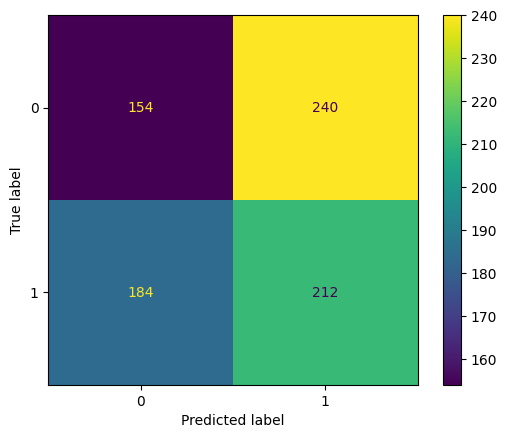

In [52]:
acc_v = accuracy_score(m_v_cv_selected['delta_y_cutoff_to_ds'], m_v_cv_selected['delta_y_cutoff_to_yhat'])
print(f"Accuracy: {acc_v:.4f}")

conf_mat_v = confusion_matrix(m_v_cv_selected['delta_y_cutoff_to_ds'], m_v_cv_selected['delta_y_cutoff_to_yhat'])
ConfusionMatrixDisplay(conf_mat_v).plot()
plt.show()

In [53]:
# Train a model for binary classification: y increase/decrease 5 days from now
forex_b = forex[['date', 'eurusd_close']].rename(columns={'date': 'ds', 'eurusd_close': 'y'})
forex_b.head()

forex_b['y_week_future'] = forex_b['y'].shift(-5)  # Calculate the difference of y
forex_b['y_difference_week'] = forex_b['y_week_future'] - forex_b['y']
forex_b = forex_b.dropna()
forex_b['y_difference'] = forex_b['y_difference_week'].apply(lambda x: 1 if x>0 else 0).astype(int)
forex_b.head()

news_b = news.merge(forex_b[['ds', 'y_difference']], left_on='date', right_on='ds')
news_b = news_b[['txt', 'y_difference']]
news_b['text_id'] = "T" + news_b.index.astype(str)
news_b.head()

,txt,y_difference,text_id
0,\rGold Price - Gold prices continue to decline...,0,T0
1,\rGBPUSD - GBP/USD Testing 1.2700 as USD Picks...,0,T1
2,\rCommodities Prices - FTSE 100 Gains As House...,1,T2
3,\rEURUSD - EUR/USD Forecast: Euro struggles to...,1,T3
4,\rOil Price - Oil prices steady as solid U.S.c...,1,T4


In [54]:
news_b_1 = news_b.sample(frac=1) # Shuffle the data

train_ratio_b = 0.7
 
total_rows_b = news_b_1.shape[0]
train_end_b = int(total_rows_b*train_ratio_b)

train_b = news_b_1[:train_end_b] # Training set
remaining_b = news_b_1[train_end_b:]

test_ratio_b = 2/3

remaining_rows_b = remaining_b.shape[0]
test_end_b = int(remaining_rows_b*test_ratio_b)

In [55]:
test_b = remaining_b[:test_end_b] # Test set
dev_b = remaining_b[test_end_b:] # Development set

path = 'C:/Users/ayata/Desktop/ammagamma-lab/project/news-1/assets'

In [56]:
train_b.to_csv(path + 'train.tsv', sep='\t', index=False, header=False)
test_b.to_csv(path + 'test.tsv', sep='\t', index=False, header=False)
dev_b.to_csv(path + 'dev.tsv', sep='\t', index=False, header=False)

In [57]:
os.chdir('C:/Users/ayata/Desktop/ammagamma-lab/project/news-1')
!spacy project run preprocess


================================= preprocess =================================
ℹ Skipping 'preprocess': nothing changed


In [58]:
!spacy project run train


=================================== train ===================================
Running command: 'c:\Users\ayata\Desktop\ammagamma-lab\project\.venv\Scripts\python.exe' -m spacy train ./configs/cnn.cfg -o training/cnn --gpu-id -1
ℹ Saving to output directory: training\cnn
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.27       50.46    0.50
  0     200          7.96       57.02    0.57
  0     400          7.03       59.28    0.59
  0     600          6.60       61.76    0.62
  0     800          6.47       63.94    0.64
  0    1000          6.33       67.01    0.67
  0    1200          6.20       69.29    0.69
  1    1400          6.04       71.14    0.71
  1    1600          5.

In [59]:
!spacy project run evaluate


================================== evaluate ==================================
Running command: 'c:\Users\ayata\Desktop\ammagamma-lab\project\.venv\Scripts\python.exe' -m spacy evaluate ./training/cnn/model-best ./corpus/test.spacy --output ./metrics/cnn.json
ℹ Using CPU

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   83.47 
SPEED                 22553 


=========================== Textcat F (per label) ===========================

                     P       R       F
admiration       67.20   58.53   62.57
amusement        76.51   81.44   78.90
anger            58.43   26.26   36.24
annoyance        39.58   11.88   18.27
approval         50.37   19.37   27.98
caring           52.08   18.52   27.32
confusion        43.08   18.30   25.69
curiosity        48.13   31.69   38.22
desire           51.61   19.28   28.07
disappointment   42.86    1.99    3.80
disapproval      39.77   13.11   19.72
disgust    

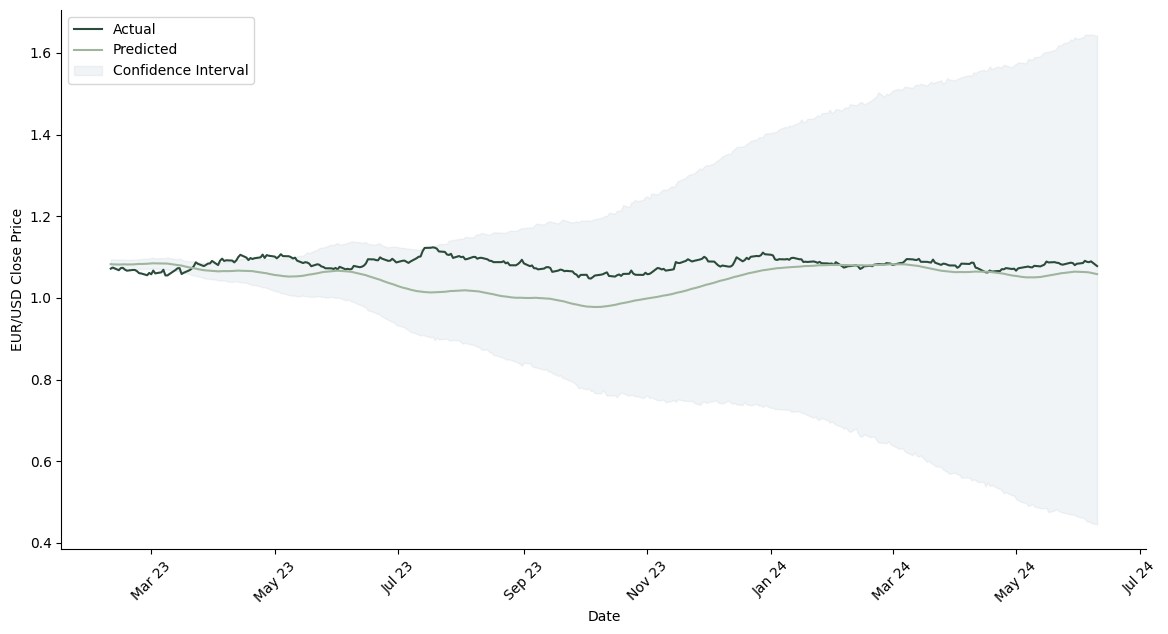

In [92]:
#model 1: future from past

plt.figure(figsize=(14, 7))
actual_line, = plt.plot(forex_test['ds'], forex_test['y'], label='Actual', color='#2c4c3b')
predicted_line, = plt.plot(forex_test_1['ds'], forex_test_1['yhat'], label='Predicted', color='#9fb59d')
plt.fill_between(forex_test_1['ds'], forex_test_1['yhat_lower'], forex_test_1['yhat_upper'], color='#b9c9d4', alpha=0.2)
confidence_interval_patch = mpatches.Patch(color='#b9c9d4', alpha=0.2, label='Confidence Interval')
plt.legend(handles=[actual_line, predicted_line, confidence_interval_patch], loc='upper left')

plt.xlabel('Date')
plt.ylabel('EUR/USD Close Price')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid(False)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
plt.xticks(rotation=45)
plt.show()

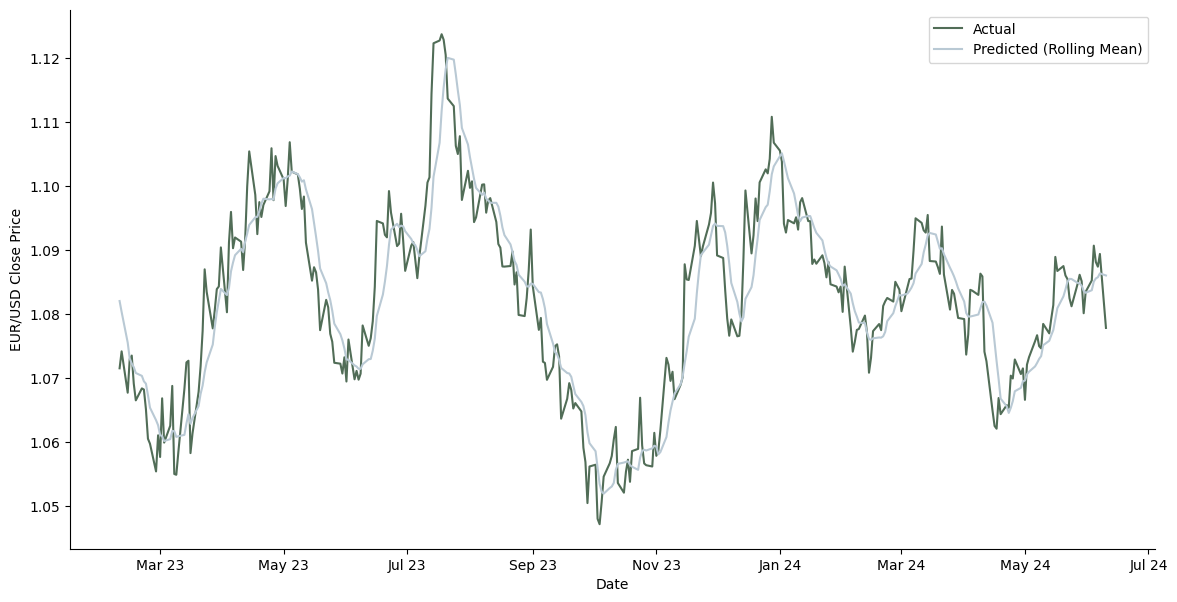

In [116]:
#model 2: using 7 past values
plt.figure(figsize=(14, 7))
plt.plot(forex_test_rm['date'], forex_test_rm['eurusd_close'], label='Actual', color='#516d57')
plt.plot(forex_test_rm['date'], forex_test_rm['yhat_rm'], label='Predicted (Rolling Mean)', color='#b9c9d4')

plt.xlabel('Date')
plt.ylabel('EUR/USD Close Price')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()
plt.show()


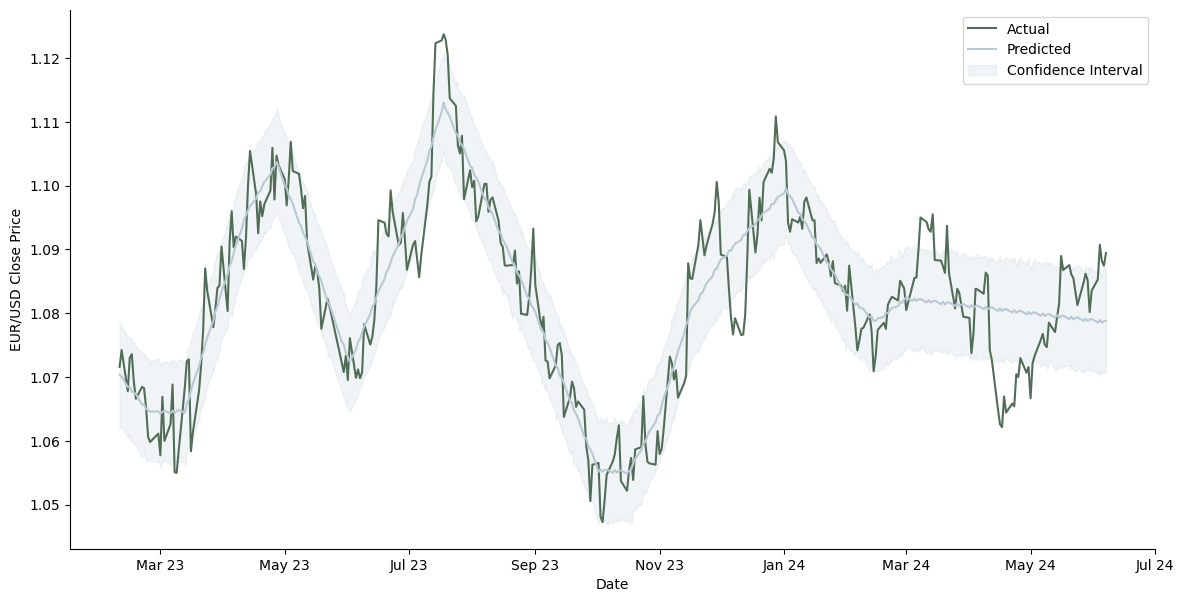

In [98]:
#model 3: future from past with setiment
plt.figure(figsize=(14, 7))
actual_line, = plt.plot(forex_test_s['ds'], forex_test_s['y'], label='Actual', color='#516d57')
predicted_line, = plt.plot(forex_test_s_1['ds'], forex_test_s_1['yhat'], label='Predicted', color='#b9c9d4')
plt.fill_between(forex_test_s_1['ds'], forex_test_s_1['yhat_lower'], forex_test_s_1['yhat_upper'], color='#b9c9d4', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('EUR/USD Close Price')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(handles=[actual_line, predicted_line, mpatches.Patch(color='#b9c9d4', alpha=0.2, label='Confidence Interval')])
plt.show()


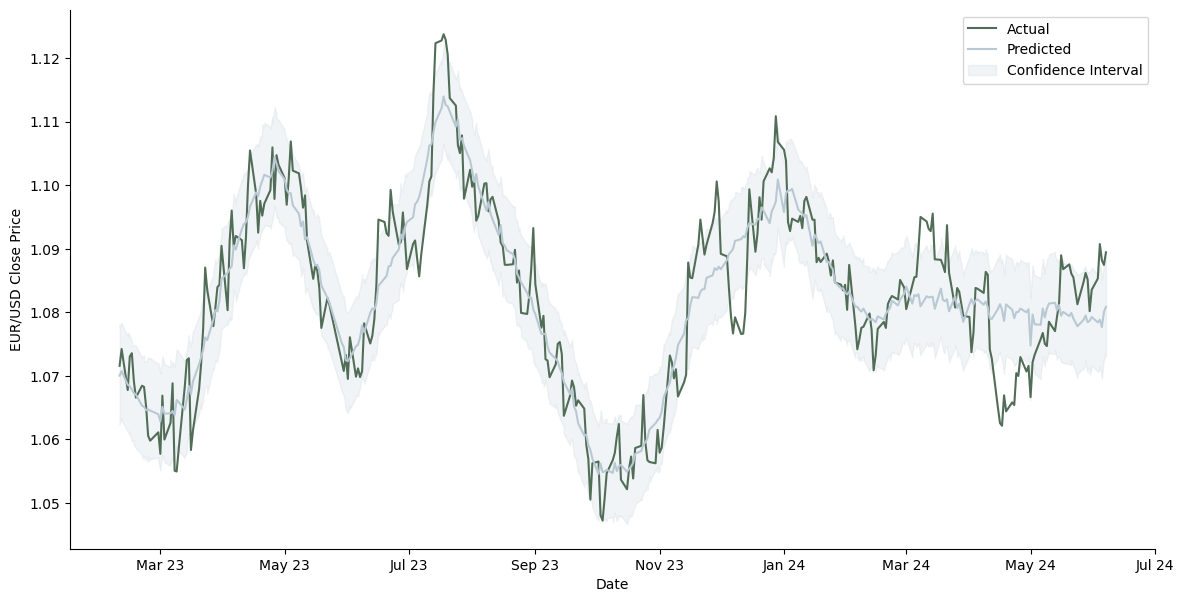

In [100]:
#model 4: future from past + sentiment + vaccination 
plt.figure(figsize=(14, 7))
actual_line, = plt.plot(forex_test_v['ds'], forex_test_v['y'], label='Actual', color='#516d57')
predicted_line, = plt.plot(forex_test_v_1['ds'], forex_test_v_1['yhat'], label='Predicted', color='#b9c9d4')
plt.fill_between(forex_test_v_1['ds'], forex_test_v_1['yhat_lower'], forex_test_v_1['yhat_upper'], color='#b9c9d4', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('EUR/USD Close Price')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend(handles=[actual_line, predicted_line, mpatches.Patch(color='#b9c9d4', alpha=0.2, label='Confidence Interval')])
plt.show()


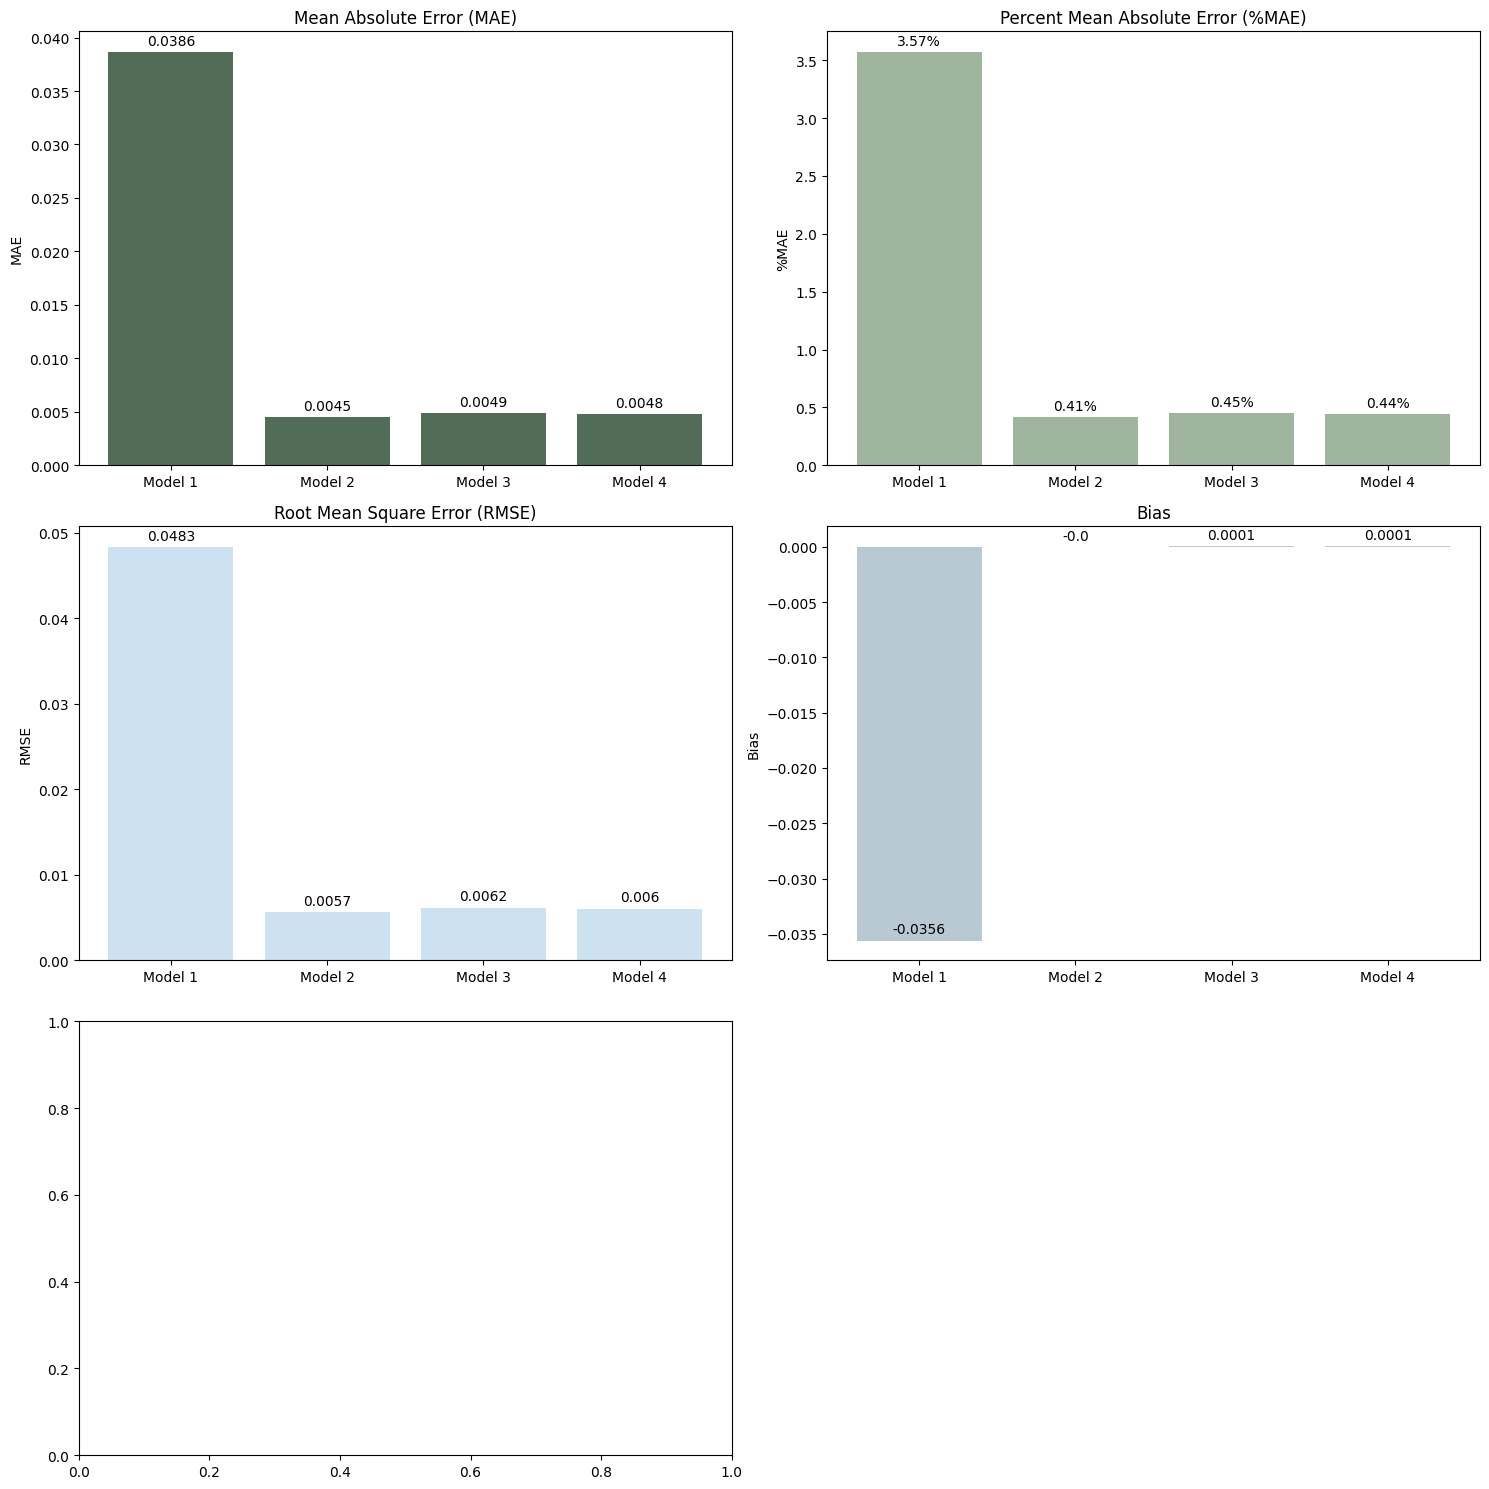

In [122]:
#accuracy metrics comparison
metrics = {
    'Model': ['Model 1', 'Model 2', 'Model 3', 'Model 4'],
    'MAE': [mae, mae_rm, mae_s, mae_v],
    '%MAE': [percent_mae_value, percent_mae_value_rm, percent_mae_value_s, percent_mae_value_v],
    'RMSE': [rmse, rmse_rm, rmse_s, rmse_v],
    'Bias': [bias_value, bias_value_rm, bias_value_s, bias_value_v],
    'Accuracy': [None, None, acc_s, acc_v]
}
metrics_df = pd.DataFrame(metrics)

fig, axs = plt.subplots(3, 2, figsize=(15, 15))
bar1 = axs[0, 0].bar(metrics_df['Model'], metrics_df['MAE'], color='#516d57')
axs[0, 0].set_title('Mean Absolute Error (MAE)')
axs[0, 0].set_ylabel('MAE')
for bar in bar1:
    height = bar.get_height()
    axs[0, 0].annotate('{}'.format(round(height, 4)),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

# Plot %MAE
bar2 = axs[0, 1].bar(metrics_df['Model'], metrics_df['%MAE'], color='#9fb59d')
axs[0, 1].set_title('Percent Mean Absolute Error (%MAE)')
axs[0, 1].set_ylabel('%MAE')
for bar in bar2:
    height = bar.get_height()
    axs[0, 1].annotate('{}%'.format(round(height, 2)),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

# Plot RMSE
bar3 = axs[1, 0].bar(metrics_df['Model'], metrics_df['RMSE'], color='#cce2f0')
axs[1, 0].set_title('Root Mean Square Error (RMSE)')
axs[1, 0].set_ylabel('RMSE')
for bar in bar3:
    height = bar.get_height()
    axs[1, 0].annotate('{}'.format(round(height, 4)),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')

# Plot Bias
bar4 = axs[1, 1].bar(metrics_df['Model'], metrics_df['Bias'], color='#b9c9d4')
axs[1, 1].set_title('Bias')
axs[1, 1].set_ylabel('Bias')
for bar in bar4:
    height = bar.get_height()
    axs[1, 1].annotate('{}'.format(round(height, 4)),
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')


axs[2, 1].axis('off')

plt.tight_layout()
plt.show()
